In [88]:
def convert_to_int(list):
    return [int(item) for item in list]

def convert_string_to_np_date(string):
    split = string.split('/')
    
    first = split[1]
    zero = split[0]
    
    if len(split[1]) == 1:
        first = '0' + split[1]
        
    if len(split[0]) == 1:
        zero = '0' + split[0]
    
    return split[2] + '-' + first + '-' + zero

def convert_string_to_excel_date(string):
    split = str(string).split('-')
    
    second = split[2]
    first = split[1]
    
    if second[0] == '0':
        second = second[1]
        
    if first[0] == '0':
        first = first[1]
    
    return second + '/' + first + '/' + split[0]

# gspread and oauth2client are necessary
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Use creds to create a client to interact with the Google Drive API
scope = [
    'https://spreadsheets.google.com/feeds',
    'https://www.googleapis.com/auth/spreadsheets',
    "https://www.googleapis.com/auth/drive.file",
    "https://www.googleapis.com/auth/drive",
]

creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
client = gspread.authorize(creds)

sheet = client.open('Denmark Covid-19 Data').get_worksheet(0)

date_full_column = sheet.col_values(1)   # Column A
i_full_column = sheet.col_values(3)      # Column C

start_date = '21/10/2021' # Included - must be in Google Sheets
end_date = '22/11/2021'   # Included - must be in Google Sheets

start_index = date_full_column.index(start_date)
end_index = date_full_column.index(end_date)

# end_index + 1 to include the end date
date_column = date_full_column[start_index : end_index + 1]
i_column = convert_to_int(i_full_column[start_index : end_index + 1])

Alfa = 0.01 , Beta = 0.2358813442281813 0.04728098946219549
y = 0.047281x + 9.325264


<IPython.core.display.Javascript object>


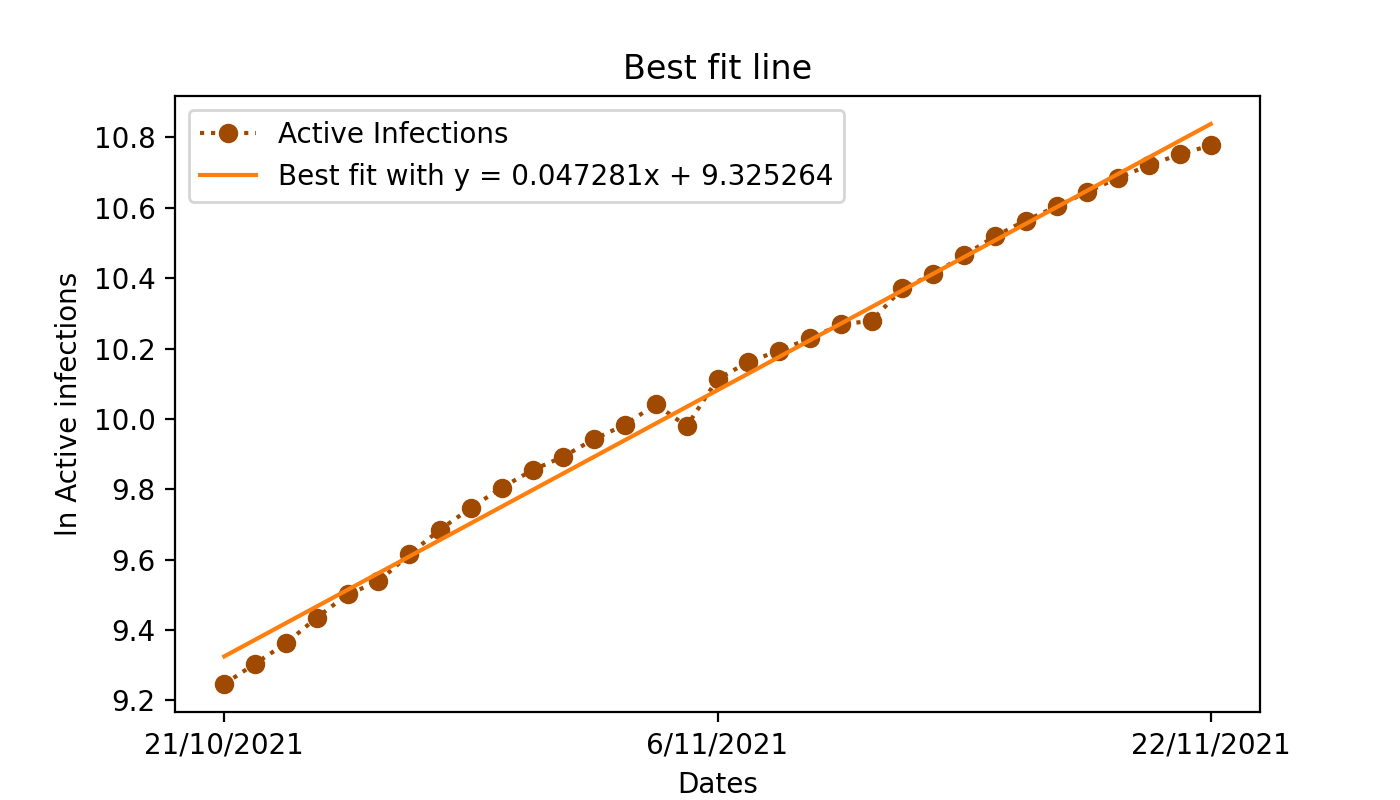

<IPython.core.display.Javascript object>


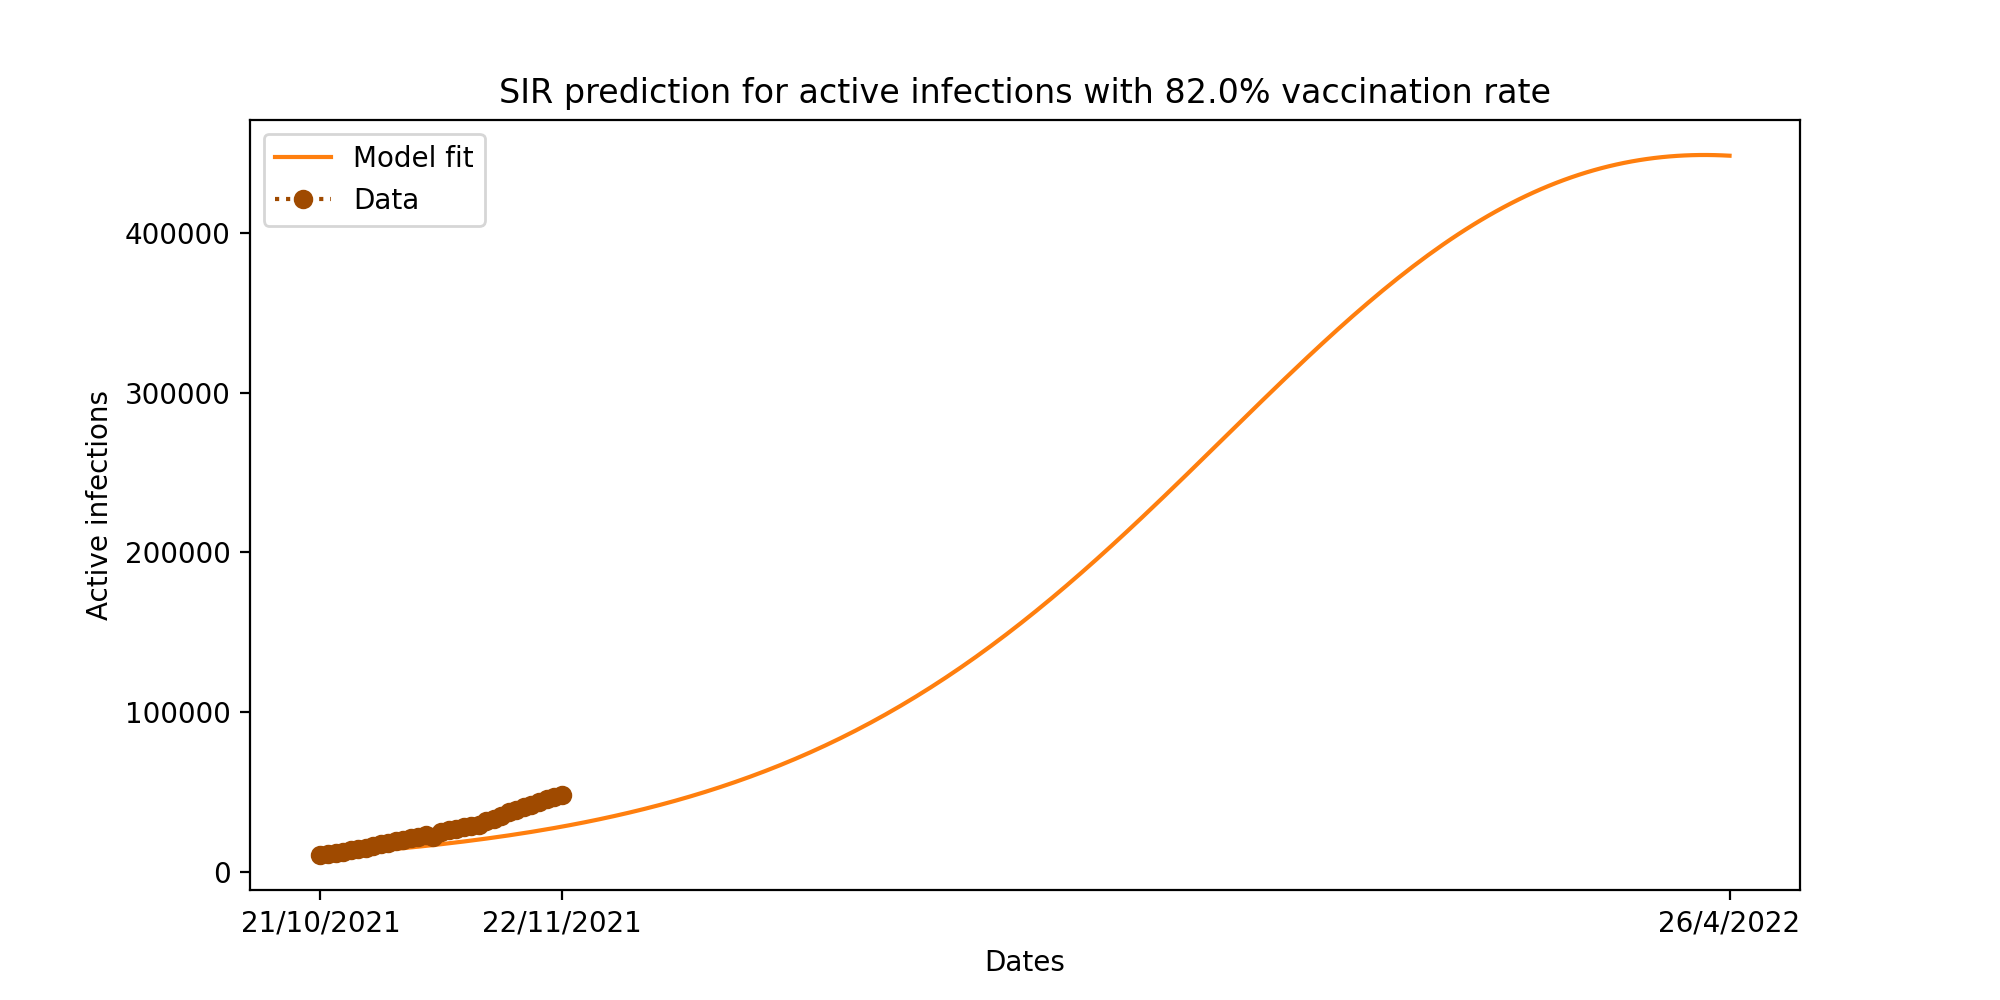

In [99]:
N = 5822763
SSI_vaccinated = 4398404 # until 21/10/2021 (around 75%)
SIR_percent = 0.82
SIR_vaccinated = SIR_percent * N #

import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

x = np.array(range(len(i_column)))
y = np.log(i_column)

p = np.polyfit(x, y, 1)

m = p[0]  # Slope
b = p[1]  # Intersection at x = 0

alfa = 1 / 100#1 / 14

# mistake - should be S
beta = (N / (N - SSI_vaccinated - i_column[0])) * (alfa + m)

print('Alfa =', alfa, ', Beta =', beta, m)
print("y = %fx + %f" % (m,b))

x_fit = np.arange(0, len(i_column), 1)
y_fit = np.polyval(p, x_fit)

plt.figure(figsize = (7, 4))

plt.title('Best fit line')

plt.plot(date_column, y, ':o', label = 'Active Infections', color = '#9F4A00')
plt.plot(date_column, y_fit, '-', label = "Best fit with y = %fx + %f" % (m,b), color = '#FF7F0E')
xticks = [date_column[0], date_column[int(len(date_column) / 2)], date_column[-1]]
plt.legend()
plt.xticks(xticks, visible = True, rotation = "horizontal")

plt.xlabel('Dates')
plt.ylabel('ln Active infections')

plt.show()

# 5000 N
# 2000 V

# 5000 - 2000 - 100 = 2900 S
# 100 I
# 5000 - 2900 - 100 = 2000 R


# 5000 - 2000 = 3000 S
# 100 I
# 2000 - 100 = 1900 R


# 5000 - 100 = 4900 S - 2000V
# 100 I
# 0 R + 2000 V

sir_s = N - SIR_vaccinated - i_column[0]
sir_i = i_column[0]
sir_r = SIR_vaccinated


sir_s_list = [sir_s]
sir_i_list = [sir_i]
sir_r_list = [sir_r]

final_date = '26/4/2022' # Included - can be not in the Google Sheets. Default - 3/12/2021

# https://stackoverflow.com/questions/12137277/how-can-i-make-a-python-numpy-arange-of-datetime
final_date_column_np = np.arange(np.datetime64(convert_string_to_np_date(start_date)),
                       np.datetime64(convert_string_to_np_date(final_date)) + np.timedelta64(1, 'D'))

final_date_column = []

for date in final_date_column_np:
    final_date_column.append(convert_string_to_excel_date(date))
    
period = len(final_date_column)

for index in range(period - 1): # Length - 1 because there are initial values
    sir_s_rate = -1 * sir_s * sir_i * beta / N
    sir_i_rate = (sir_s * sir_i * beta / N) - (sir_i * alfa)
    sir_r_rate = sir_i * alfa

    sir_s += sir_s_rate
    sir_i += sir_i_rate
    sir_r += sir_r_rate

    sir_s_list.append(sir_s)
    sir_i_list.append(sir_i)
    sir_r_list.append(sir_r)

new_i_column = i_column.copy()

# 2    0 1
# 4    0 1 2 3

for i in range(period):
    if i >= len(new_i_column):
        new_i_column.append(None)


xticks = [start_date, end_date, final_date]
        
plt.figure(figsize = (10, 5))
plt.title('SIR prediction for active infections with ' + str(SIR_percent * 100) + '% vaccination rate')
plt.plot(final_date_column, sir_i_list, '-', label = 'Model fit', color = '#FF7F0E')
plt.plot(final_date_column, new_i_column, ':o', label = 'Data', color = '#9F4A00')
plt.legend()

plt.ylabel('Active infections')
plt.xlabel('Dates')

plt.xticks(xticks, visible = True, rotation = "horizontal")
plt.savefig('./Images/prediction.png')

plt.show()